In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from IPython import display

import theano
import theano.tensor as T
import lasagne

from lfw_dataset import fetch_lfw_dataset

Using gpu device 0: GRID K520 (CNMeM is disabled)


# Variational Autoencoder (VAE)

Useful links: 
* original paper http://arxiv.org/abs/1312.6114
* helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this seminalr we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [2]:
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data,attrs = fetch_lfw_dataset()

In [3]:
data.shape

(13143, 45, 45, 3)

In [4]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [5]:
X_train = np.float32(X_train)
X_train = X_train / 255
X_val = np.float32(X_val)
X_val = X_val / 255

In [6]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

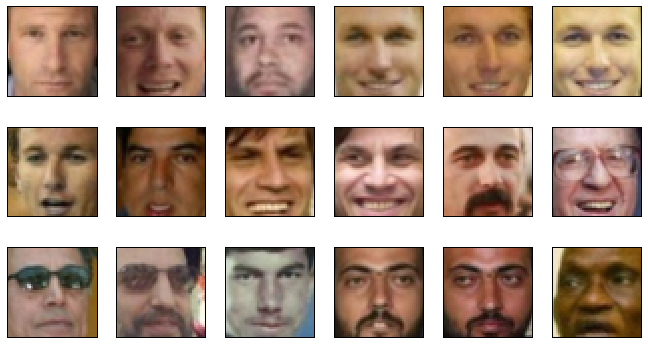

In [7]:
plot_gallery(X_train, image_h, image_w)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [8]:
input_X = T.matrix("X")

input_shape = [None, image_h * image_w * 3]

In [9]:
HU_encoder = 2000 #you can play with this values
HU_decoder = 2000
dimZ = 1000 #considering face reconstruction task, which size of representation seems reasonable?

# define the network
# use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# zero initialization for biases
# it's also convenient to put sigmoid activation on output layer to get nice normalized pics

l_input = lasagne.layers.InputLayer(input_var=input_X, shape=input_shape)
l_enc = lasagne.layers.DenseLayer(l_input, num_units=HU_encoder,
                                  nonlinearity=lasagne.nonlinearities.rectify,
                                  W=lasagne.init.GlorotUniform())
l_z = lasagne.layers.DenseLayer(l_enc, num_units=dimZ,
                                  nonlinearity=lasagne.nonlinearities.rectify,
                                  W=lasagne.init.GlorotUniform())
l_dec = lasagne.layers.DenseLayer(l_z, num_units=HU_decoder,
                                  nonlinearity=lasagne.nonlinearities.rectify,
                                  W=lasagne.init.GlorotUniform())
l_output = lasagne.layers.DenseLayer(l_dec, num_units=image_h * image_w * 3,
                                  nonlinearity=lasagne.nonlinearities.sigmoid,
                                  W=lasagne.init.GlorotUniform())

In [10]:
# create prediction variable
prediction = lasagne.layers.get_output(l_output)

# create loss function
loss = lasagne.objectives.squared_error(prediction, input_X).mean()

# create parameter update expressions
params = lasagne.layers.get_all_params(l_output, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=0.001)

# compile training function that updates parameters and returns training loss
# this will take a while
train_fn = theano.function([input_X], loss, updates=updates)
test_fn = theano.function([input_X], prediction)

In [11]:
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]
        

In [12]:
# train your autoencoder
# visualize progress in reconstruction and loss decay

n_epochs = 50
batchsize = 512
train_loss = []
test_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    epoch_loss = 0.
    k = 0
    for batch in iterate_minibatches(X_train, batchsize):
        epoch_loss += train_fn(batch)
        k += 1
    pred = test_fn(X_val)
    test_loss.append(np.mean((pred - X_val) ** 2))
    train_loss.append(epoch_loss / k)
    t = time.time() - start_time
    display.clear_output(wait=True)
    
    print("Epoch {:d} is completed".format(epoch + 1))
    print(" - training loss (batch average): {:.5f}".format(train_loss[-1]))
    print(" - test loss: {:.5f}".format(test_loss[-1]))
    print(" - time: {:.2f} s".format(t))

Epoch 50 is completed
 - training loss (batch average): 0.00525
 - test loss: 0.00510
 - time: 2.68 s


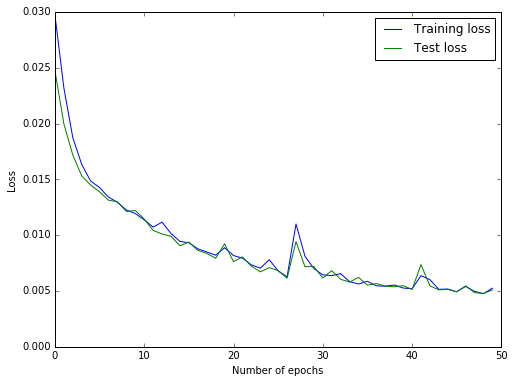

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Test loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

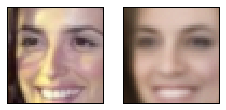

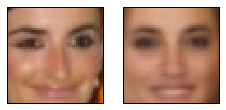

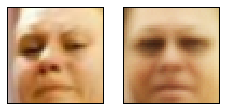

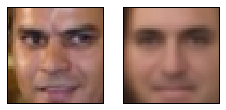

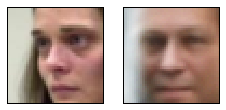

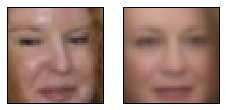

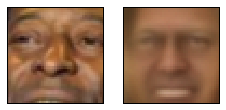

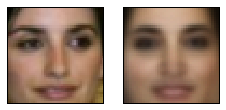

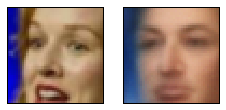

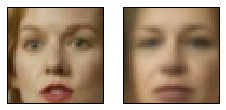

In [14]:
for batch in iterate_minibatches(X_val[:10], 1):
    pred = test_fn(batch)
    plot_gallery([batch[0],pred], image_h, image_w, n_row=1, n_col=2)

# Sampling

This task requires deeper Lasagne knowledge. You need to perform inference from $z$, reconstruct an image given some random $z$ representations.

In [15]:
z_sample = T.matrix()

# Your code goes here:
generated_x = lasagne.layers.get_output(l_output, {l_z:z_sample})

gen_x = theano.function([z_sample], generated_x)

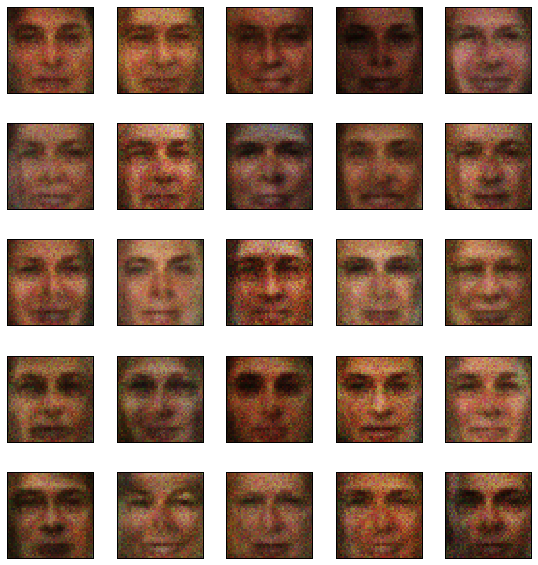

In [16]:
z = np.random.randn(25, dimZ) * 0.5
output = gen_x(np.asarray(z, dtype=theano.config.floatX))
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

Can you visualize how the distribution of $z$ looks like? Is it dense? What properties would we expect from it? Can we perform interpolation in $z$ space?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution q(z|x). Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick is implemented via the **GaussianSampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon$

The code for this layer taken from "recipes" folder of Lasagne github repo:

In [17]:
from GS import *

#reload(GS)

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average like it is in Lasagne recipes.

In [18]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before

HU_encoder = 2000
HU_decoder = 2000
dimZ = 1000

# define the network
# you can start from 
# https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# or another example https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

l_input_vae = lasagne.layers.InputLayer(input_var=input_X, shape=input_shape)

l_enc_vae = lasagne.layers.DenseLayer(l_input_vae, num_units=HU_encoder,
                                  nonlinearity=lasagne.nonlinearities.rectify,
                                  W=lasagne.init.GlorotUniform())

l_enc_mu_vae = lasagne.layers.DenseLayer(l_enc_vae, num_units=dimZ,
                                  nonlinearity=None,
                                  W=lasagne.init.GlorotUniform())

l_enc_logsigma_vae = lasagne.layers.DenseLayer(l_enc_vae, num_units=dimZ,
                                  nonlinearity=None,
                                  W=lasagne.init.GlorotUniform())

l_z_vae = GaussianSampleLayer(l_enc_mu_vae, l_enc_logsigma_vae)

l_dec_vae = lasagne.layers.DenseLayer(l_z_vae, num_units=HU_decoder,
                                  nonlinearity=lasagne.nonlinearities.rectify,
                                  W=lasagne.init.GlorotUniform())

l_dec_mu_vae = lasagne.layers.DenseLayer(l_dec_vae, num_units=image_h * image_w * 3,
                                  nonlinearity=None,
                                  W=lasagne.init.GlorotUniform())

l_dec_logsigma_vae = lasagne.layers.DenseLayer(l_dec_vae, num_units=image_h * image_w * 3,
                                  nonlinearity=None,
                                  W=lasagne.init.GlorotUniform())

l_output_vae = GaussianSampleLayer(l_dec_mu_vae, l_dec_logsigma_vae)

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = \frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [19]:
def KL_divergence(mu, logsigma):
    return - 0.5 * T.sum(1 + 2 * logsigma - T.sqr(mu) - T.exp(2 * logsigma))

def log_likelihood(x, mu, logsigma):
    return T.sum(-0.5 * np.log(2 * np.pi) - logsigma - 0.5 * T.sqr(x - mu) / T.exp(2 * logsigma))

In [20]:
lasagne.layers.get_all_layers(l_output_vae) # should be ~9 layers total

Now build the loss and training function:

In [21]:
# create prediction variable
prediction_vae = lasagne.layers.get_output(l_output_vae, deterministic=True)

# create loss function
# loss = KL_divergence(..., ...) + log_likelihood(..., ..., ...)

enc_mu = lasagne.layers.get_output(l_enc_mu_vae)
enc_logsigma = lasagne.layers.get_output(l_enc_logsigma_vae)
dec_mu = lasagne.layers.get_output(l_dec_mu_vae)
dec_logsigma = lasagne.layers.get_output(l_dec_logsigma_vae)

loss_vae = KL_divergence(enc_mu, enc_logsigma) - log_likelihood(input_X, dec_mu, dec_logsigma).mean()

# create parameter update expressions
params_vae = lasagne.layers.get_all_params(l_output_vae, trainable=True)
updates_vae = lasagne.updates.adam(loss_vae, params_vae, learning_rate=0.0001)

# compile training and testing functions
train_fn_vae = theano.function([input_X], loss_vae, updates=updates_vae)
test_fn_vae = theano.function([input_X], prediction_vae) 

And train the model:

In [22]:
# train your autoencoder
# visualize progress in reconstruction and loss decay

n_epochs = 50
batchsize = 512
train_loss = []
test_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    epoch_loss = 0.
    k = 0
    for batch in iterate_minibatches(X_train, batchsize):
        train_fn_vae(batch)
        k += 1
    pred = test_fn_vae(X_val)
    test_loss.append(np.mean((pred - X_val) ** 2))
    train_loss.append(epoch_loss / k)
    t = time.time() - start_time
    display.clear_output(wait=True)
    
    print("Epoch {:d} is completed".format(epoch + 1))
    print(" - test loss: {:.5f}".format(test_loss[-1]))
    print(" - time: {:.2f} s".format(t))

Epoch 50 is completed
 - test loss: 0.00397
 - time: 5.25 s


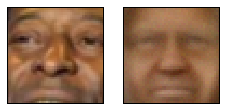

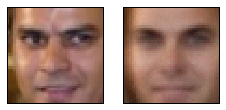

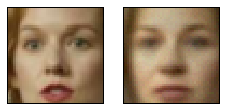

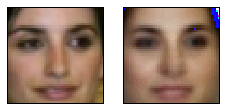

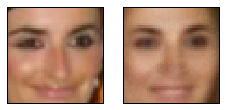

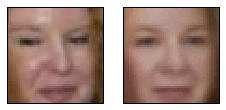

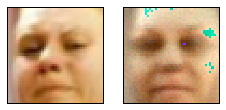

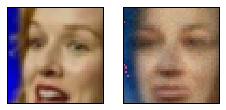

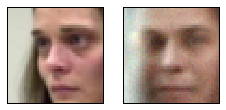

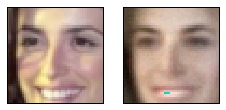

In [48]:
for batch in iterate_minibatches(X_val[:10], 1):
    pred = test_fn_vae(batch)
    plot_gallery([batch[0],pred], image_h, image_w, n_row=1, n_col=2)

# Congrats!

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" column as a separate numpy vector and sort this vector.

In [23]:
attrs[:10]

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,...,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,...,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,...,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,...,-1.46147,-0.955283,0.119113,-1.12818,-3.16105,0.0826804,-0.439614,-0.359859,-0.760774,-0.410152
5,0.850491,-1.48208,1.90852,-1.87365,-3.22993,-0.864006,0.31382,-0.35268,-1.55929,-1.91459,...,1.77547,-1.0635,1.35435,-0.960133,-5.35464,1.15002,-0.142195,-0.672725,0.886694,-0.154051
6,0.944548,-1.37722,1.29906,-1.40534,-1.86233,-0.502664,-0.48629,0.0150016,-0.892478,-0.586615,...,0.155763,-0.0333257,-0.869705,-0.942216,-3.77615,-1.0283,0.0992853,-0.335493,0.185644,-0.671966
7,1.59467,-1.50443,0.441401,-1.77175,-2.44985,-1.10597,-0.0425912,-0.136437,-1.00851,0.653294,...,-3.25803,0.128691,-1.57324,-1.10214,-1.12391,-1.39417,1.52065,-0.487475,0.601968,-0.617698
8,0.286489,-1.90351,0.697239,-1.85985,-1.44025,-1.55243,0.102555,-0.191471,-0.726333,-0.226157,...,-1.41784,-0.483956,0.717483,-0.288405,-2.29545,0.937971,1.23307,-0.632812,0.00999485,-0.144265
9,0.663497,-1.03694,0.46161,-2.49853,-2.81593,-1.63779,-0.20148,-0.134941,-1.32816,-0.712721,...,1.43291,0.771419,1.59549,-0.697505,-2.51197,0.98124,0.424768,-0.518236,-0.306921,0.348492


In [34]:
smiling_idx = attrs['Smiling'][:10000].values.argsort()

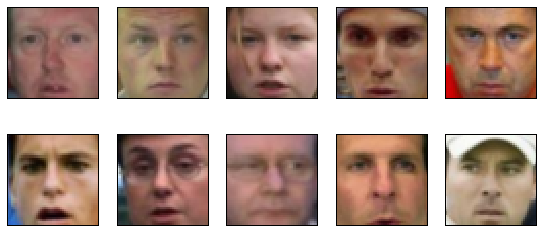

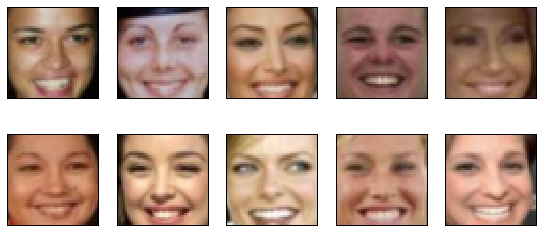

In [35]:
#show top- and bottom-10 faces of sorted

plot_gallery(X_train[smiling_idx[:10]], image_h, image_w, n_row=2, n_col=5)
plot_gallery(X_train[smiling_idx[-10:]], image_h, image_w, n_row=2, n_col=5)

2) Take z-representations of those top images (you can do it only for positive or for both) and average them to find **"vector representation"** of the attribute.

In [36]:
get_z = lasagne.layers.get_output(l_z, deterministic=True)
encode = theano.function([input_X], get_z)

get_z_vae = lasagne.layers.get_output(l_z_vae, deterministic=True)
encode_vae = theano.function([input_X], get_z_vae)

In [40]:
z_not_smiling = encode(X_train[smiling_idx[:10]])
z_smiling = encode(X_train[smiling_idx[-10:]])
smiling_vector = z_smiling.mean(axis=0) - z_not_smiling.mean(axis=0)

z_not_smiling_vae = encode_vae(X_train[smiling_idx[:10]])
z_smiling_vae = encode_vae(X_train[smiling_idx[-10:]])
smiling_vector_vae = z_smiling_vae.mean(axis=0) - z_not_smiling_vae.mean(axis=0)

3) Show how **"feature arithmetics"** works with representations of both VAE and conventional autoencoder. Show how to generate an image with preconditioned attribute. Take some sad faces and make them smiling.

4) (If you didn't manage to tune VAE, just show if it works for just AE.) Discuss the results.m

In [49]:
z_sample = T.matrix()

generated_x = lasagne.layers.get_output(l_output, {l_z:z_sample}, deterministic=True) 
gen_x = theano.function([z_sample], generated_x)

z_not_smiling_mod = z_not_smiling + smiling_vector
output_smiling = gen_x(z_not_smiling_mod)

generated_x_vae = lasagne.layers.get_output(l_output_vae, {l_z_vae:z_sample}, deterministic=True) 
gen_x_vae = theano.function([z_sample], generated_x_vae)

z_not_smiling_mod_vae = z_not_smiling_vae + smiling_vector_vae
output_smiling_vae = gen_x_vae(z_not_smiling_mod_vae)

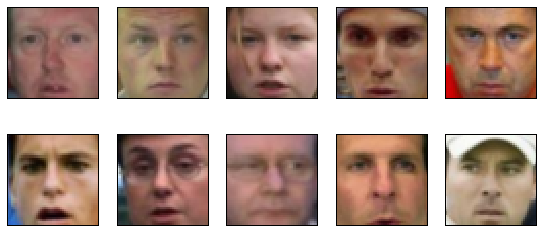

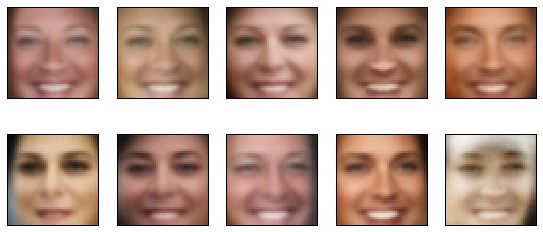

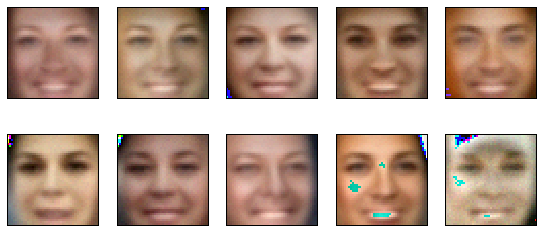

In [50]:
plot_gallery(X_train[smiling_idx[:10]], image_h, image_w, n_row = 2, n_col = 5)
plot_gallery(output_smiling, image_h, image_w,  n_row = 2, n_col = 5)
plot_gallery(output_smiling_vae, image_h, image_w,  n_row = 2, n_col = 5)

<img src="linear.png" alt="linear">